**0. Instalar e importar modulos y bibliotecas necesarias**

In [1]:
!pip install mordred
!pip install rdkit
!pip install scikit-learn
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.5 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176721 sha256=72c486d8db50500537e042dadfd83a96fbd95eee768dca5a256f3a76175285d6
  Stored in directory: /root/.cache/pip/wheels/20/88/41/5d873c9b55dc7479f0b9951c2161d7b09be193e7228ea27309
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 14.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools
from sklearn.model_selection import train_test_split
from mordred import Calculator, descriptors
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import pearsonr
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import r2_score

PandasTools.RenderImagesInAllDataFrames(images=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**1. Carga de datos**

In [3]:
df = pd.read_csv("/content/cruzain_dataset.csv")
df.head()

,ID,SMILES,pIC50,Group,Chemical family,Journal,Year,PubMed ID,DOI
0,CHEMBL90475,S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1,6.00,Train,Thiosemicarbazone,Journal of medicinal chemistry.,2002,12061873,10.1021/jm010459j
1,CHEMBL31000,OCCNc1cc[nH+]c2cc(Cl)ccc12,4.21,Train,Quinoline,Bioorganic & medicinal chemistry.,2017,28215783,10.1016/j.bmc.2017.02.009
2,CHEMBL460418,OCCCNc1cc[nH+]c2cc(Cl)ccc12,4.55,Train,Quinoline,Bioorganic & medicinal chemistry.,2017,28215783,10.1016/j.bmc.2017.02.009
3,CHEMBL3233092,O=Cc1c(OCC(=O)NCCc2nc3ccccc3[nH]2)ccc2ccccc12,4.87,Train,Amide,Journal of medicinal chemistry.,2014,24533839,10.1021/jm401709b
4,CHEMBL118596,O=C1C(=O)N(Cc2ccccc2)c2ccc(I)cc21,4.05,Train,Isatin,Bioorganic & medicinal chemistry letters.,2003,14505663,10.1016/s0960-894x(03)00756-x


,ID,SMILES,pIC50,Group,Chemical family,Journal,Year,PubMed ID,DOI,Molecule
0,CHEMBL90475,S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1,6.00,Train,Thiosemicarbazone,Journal of medicinal chemistry.,2002,12061873,10.1021/jm010459j,
1,CHEMBL31000,OCCNc1cc[nH+]c2cc(Cl)ccc12,4.21,Train,Quinoline,Bioorganic & medicinal chemistry.,2017,28215783,10.1016/j.bmc.2017.02.009,

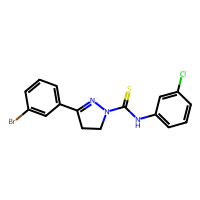
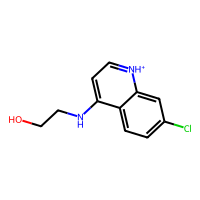

In [4]:
df["Molecule"] = df["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))
df.head(2)

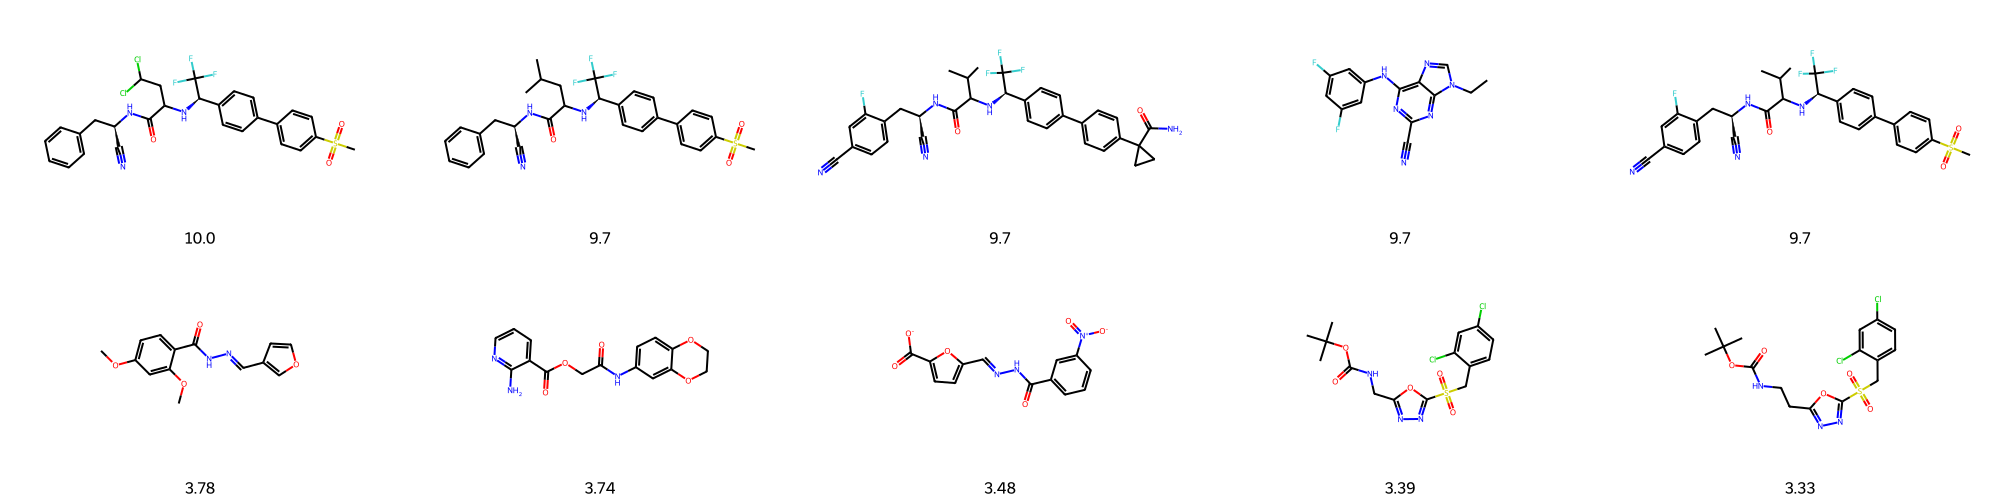

In [5]:
sample_mols = list(df.sort_values("pIC50", ascending=False).head(5)["Molecule"]) + list(df.sort_values("pIC50", ascending=False).tail(5)["Molecule"])
sample_acts = [str(x) for x in list(df.sort_values("pIC50", ascending=False).head(5)["pIC50"]) + list(df.sort_values("pIC50", ascending=False).tail(5)["pIC50"])]

Chem.Draw.MolsToGridImage(sample_mols, molsPerRow=5, subImgSize=(400,250), legends=sample_acts)

**2. Cálculo de descriptores**

In [6]:
descriptor_calculator = Calculator(descriptors, ignore_3D=True)

In [7]:
x_all = descriptor_calculator.pandas(df["Molecule"])
x_all.head()

100%|██████████| 344/344 [03:33<00:00,  1.61it/s]


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,17.217852,13.889682,0,0,28.075988,2.383341,4.665332,28.075988,1.276181,4.022011,...,9.847393,69.465556,392.970208,11.227720,1164,30,114.0,131.0,6.777778,4.805556
1,11.342218,9.590501,0,1,19.384647,2.390228,4.780455,19.384647,1.292310,3.627554,...,9.520249,46.886766,223.063267,8.261602,368,21,74.0,85.0,4.694444,3.472222
2,12.049325,10.026110,0,1,20.454812,2.390498,4.780995,20.454812,1.278426,3.686383,...,9.538564,48.078505,237.078917,7.902631,459,22,78.0,89.0,4.944444,3.722222
3,21.867940,16.197798,0,0,37.263309,2.416279,4.832357,37.263309,1.330832,4.266361,...,10.185013,77.198875,373.142641,7.939205,2461,42,146.0,171.0,7.388889,6.277778
4,14.975211,12.541993,0,0,24.948691,2.505089,4.818967,24.948691,1.313089,3.892152,...,9.927351,67.207515,362.975627,12.516401,680,30,102.0,122.0,6.027778,4.138889


**3. Partición de los datos**

3.1 Partición aleatoria

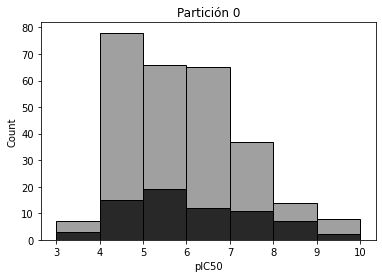

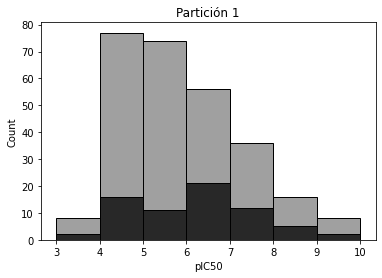

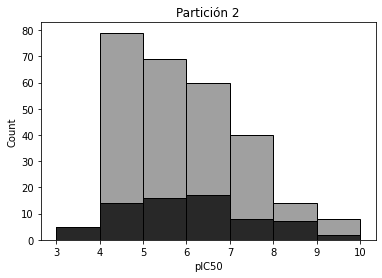

In [8]:
for i in range(3):
  x_train, x_test, y_train, y_test = train_test_split(x_all, df["pIC50"], test_size=0.20)
  plt.figure()
  plt.title("Partición {}".format(i))
  sns.histplot(y_train, bins=range(3,11), color="gray")
  sns.histplot(y_test, bins=range(3,11), color="black")
  plt.show()

3.2 Partición estratificada

In [10]:
y_train = df[df["Group"] == "Train"]["pIC50"].reset_index(drop=True)
y_test = df[df["Group"] == "Test"]["pIC50"].reset_index(drop=True)

x_train = x_all.iloc[df[df["Group"] == "Train"].index].reset_index(drop=True)
x_test = x_all.iloc[df[df["Group"] == "Test"].index].reset_index(drop=True)

print(x_train.shape, x_test.shape)

(275, 1613) (69, 1613)


**4. Limpieza de datos**

In [11]:
from mordred.error import Missing, Error

features_mask = []
for column in x_train.columns:
  if Missing not in x_train[column].apply(type).value_counts().index and Error not in x_train[column].apply(type).value_counts().index:
    features_mask.append(column)

In [12]:
x_train = x_train[features_mask]
x_train.shape

(275, 1421)

In [13]:
x_test = x_test[features_mask]
x_test.shape

(69, 1421)

**5. Escalamiento de variables**

In [14]:
scaler = MinMaxScaler()
scaler.fit(x_train)

MinMaxScaler()

In [15]:
x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)

**6. Eliminación de variables**

6.1 Por varianza nula

In [16]:
selector = VarianceThreshold()
selector.fit(x_train_scaled)
print(selector.get_feature_names_out())

['ABC' 'ABCGG' 'nAcid' ... 'Zagreb2' 'mZagreb1' 'mZagreb2']


In [17]:
x_train_scaled = x_train_scaled[selector.get_feature_names_out()]
x_test_scaled = x_test_scaled[selector.get_feature_names_out()]

In [18]:
print(x_train_scaled.shape, x_test_scaled.shape)

(275, 1242) (69, 1242)


6.2 Eliminar variables altamente correlacionadas

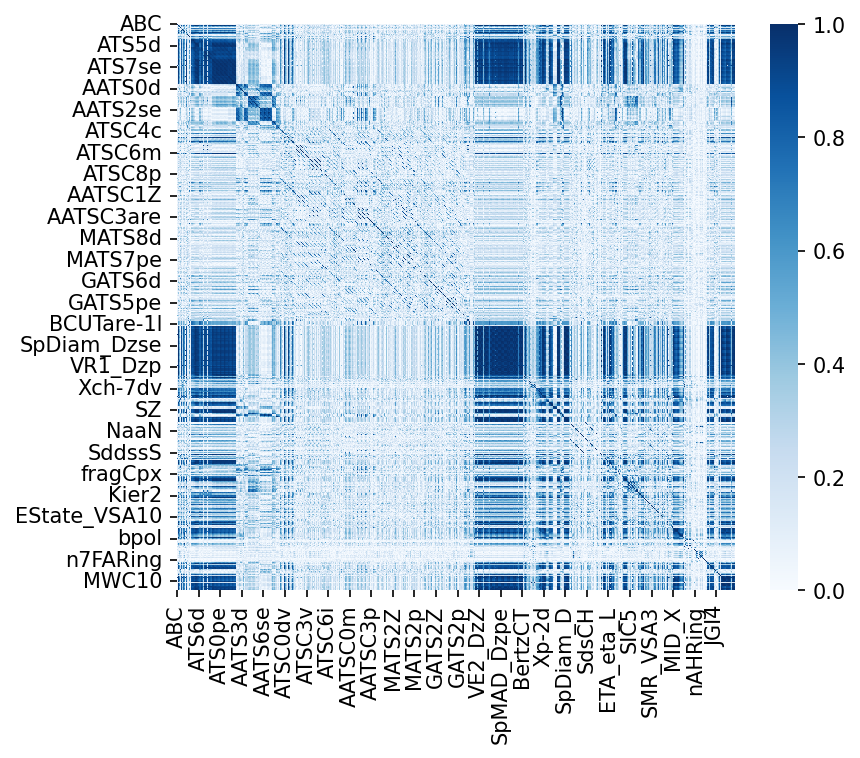

In [19]:
plt.figure(figsize=(6,5), dpi=150)
sns.heatmap(abs(x_train_scaled.corr()), vmin=0, vmax=1, cmap="Blues")
plt.show()

In [20]:
correlation_mask = []
for column in x_train_scaled.columns:
  if len(correlation_mask) == 0:
    correlation_mask.append(column)
  else:
    correlations = [abs(pearsonr(x_train[column], x_train[mask_column])[0]) for mask_column in correlation_mask]
    if max(correlations) > 0.9:
      continue
    else:
      correlation_mask.append(column)

In [21]:
x_train_scaled = x_train_scaled[correlation_mask]
x_test_scaled = x_test_scaled[correlation_mask]
print(x_train_scaled.shape, x_test_scaled.shape)

(275, 521) (69, 521)


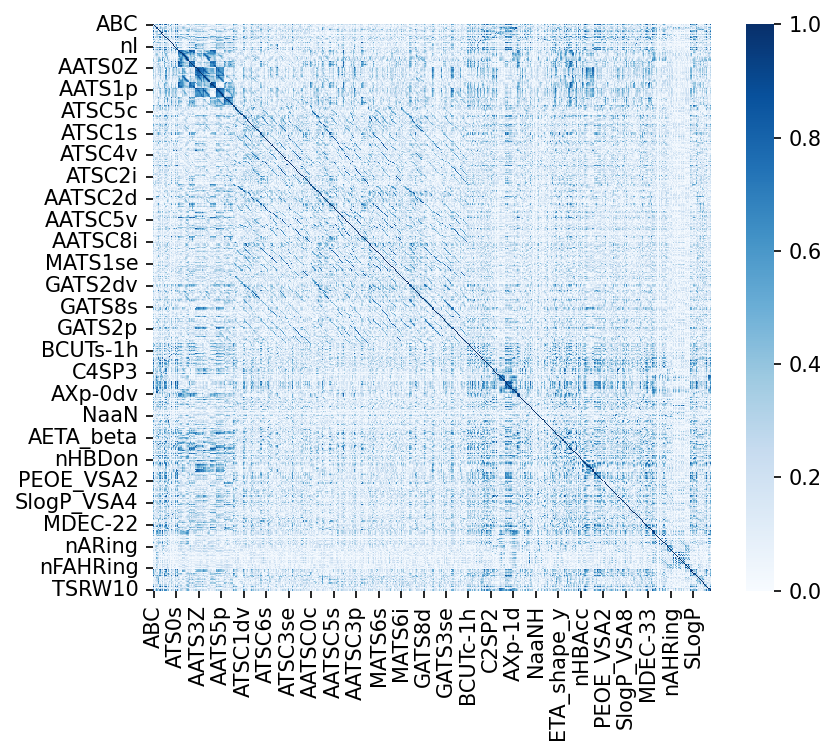

In [22]:
plt.figure(figsize=(6,5), dpi=150)
sns.heatmap(abs(x_train_scaled.corr()), vmin=0, vmax=1, cmap="Blues")
plt.show()

**7. Entrenamiento de los modelos (validación interna)**

In [23]:
regressor = KNeighborsRegressor(n_neighbors=5, weights="distance")

In [24]:
cross_val_score(regressor, x_train_scaled, y_train, cv=5, scoring="r2")

array([0.06206787, 0.52851789, 0.58408456, 0.65872107, 0.17680756])

7.1 Selección aleatoria de variables (KFold=5)

In [25]:
results = []
for i in range(5000):
  selected_features = random.choices(x_train_scaled.columns, k=9)
  results.append([selected_features, cross_val_score(regressor, x_train_scaled[selected_features], y_train, cv=5, scoring="r2")])

In [26]:
results = pd.DataFrame(results, columns=["Features", "CV_scores"])

In [27]:
results["Mean score"] = results["CV_scores"].apply(lambda x: x.mean())

In [28]:
results = results.sort_values("Mean score", ascending=False).reset_index(drop=True)
results.head()

,Features,CV_scores,Mean score
0,"[nRot, AATS5p, AATS6i, AXp-1dv, ATSC3dv, GATS1...","[0.25234105527399, 0.4791140155576191, 0.67738...",0.434803
1,"[SM1_DzZ, BCUTd-1l, NdsN, HybRatio, AATSC7v, A...","[0.45295259751872086, 0.5109665582382512, 0.51...",0.433934
2,"[nO, nRot, GATS5se, GATS1p, Xch-5dv, ATS6m, GA...","[0.21485270319270455, 0.5894553543527922, 0.48...",0.403125
3,"[ATSC1i, Lipinski, ATSC3dv, NdS, nFARing, ATSC...","[0.19054260487478525, 0.4025038863324776, 0.50...",0.398836
4,"[AATS7dv, C1SP2, SIC0, PEOE_VSA4, ETA_dAlpha_B...","[0.13244583799675047, 0.4193545563535319, 0.57...",0.386076


7.2 Validación interna (LOO)

In [29]:
loo = LeaveOneOut()
loo_pred = []
for i, (train_index, test_index) in enumerate(loo.split(x_train)):
  regressor.fit(x_train_scaled[results["Features"].iloc[0]].iloc[train_index], y_train.iloc[train_index])
  loo_pred.append(regressor.predict(x_train_scaled[results["Features"].iloc[0]].iloc[test_index])[0])

In [30]:
loo_r2 = r2_score(y_train, loo_pred)
print(loo_r2)

0.6250275333611186


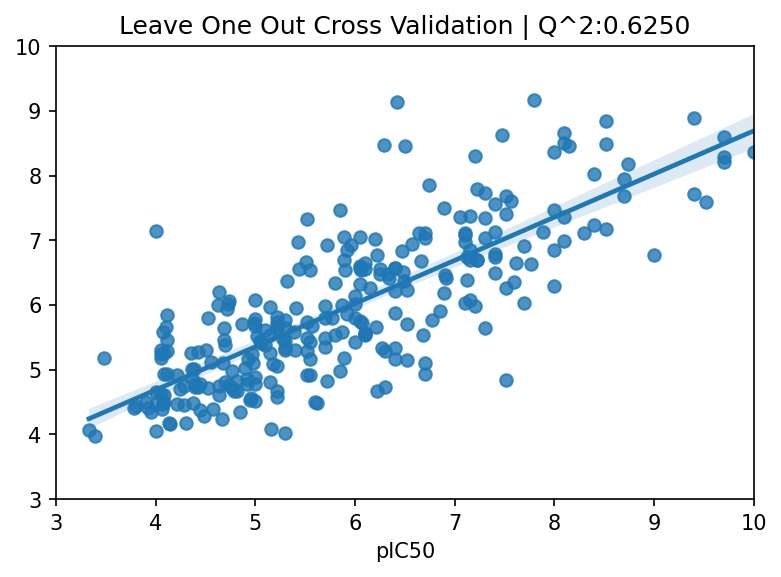

In [31]:
plt.figure(dpi=150)
sns.regplot(x=y_train, y=loo_pred)
plt.xlim(3,10)
plt.ylim(3,10)
plt.title("Leave One Out Cross Validation | Q^2:{:.4f}".format(loo_r2))
plt.show()

7.3  Validación externa

In [32]:
best_regressor = regressor.fit(x_train_scaled[results["Features"].iloc[0]], y_train)

In [33]:
ext_pred = regressor.predict(x_test_scaled[results["Features"].iloc[0]])

In [34]:
ext_r2 = r2_score(y_test, ext_pred)
print(ext_r2)

0.5836975449252294


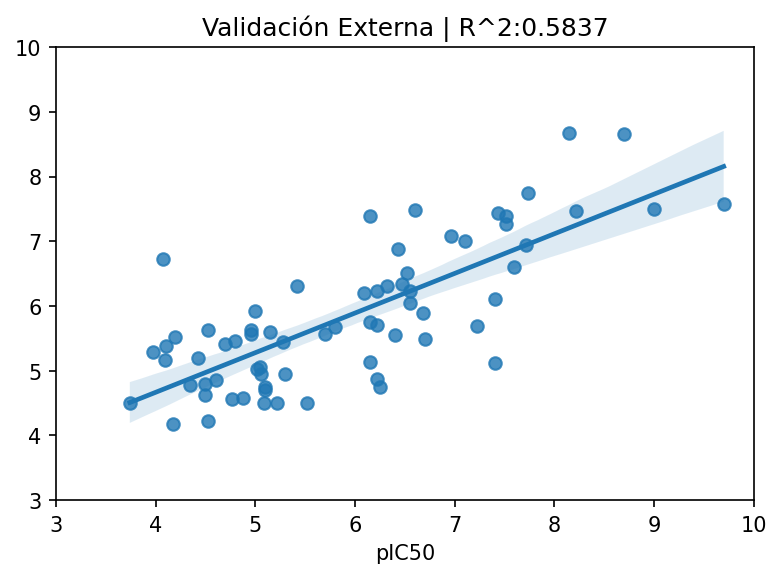

In [35]:
plt.figure(dpi=150)
sns.regplot(x=y_test, y=ext_pred)
plt.xlim(3,10)
plt.ylim(3,10)
plt.title("Validación Externa | R^2:{:.4f}".format(ext_r2))
plt.show()